<a href="https://colab.research.google.com/github/susumu2357/US-patent-analysis/blob/master/colab/ArcFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
!mkdir -p ./data

!gsutil cp gs://mlstudy-phys/data/grants_for_3000+3000.df.gz ./data/ 
!gsutil cp gs://mlstudy-phys/data/testset_app_3000.df.gz ./data/
!gsutil cp gs://mlstudy-phys/data/training_app_3000.df.gz ./data/
!gsutil cp gs://mlstudy-phys/data/citations_info_3000+3000.df.gz ./data/ 

Copying gs://mlstudy-phys/data/grants_for_3000+3000.df.gz...
\ [1 files][129.4 MiB/129.4 MiB]                                                
Operation completed over 1 objects/129.4 MiB.                                    
Copying gs://mlstudy-phys/data/testset_app_3000.df.gz...
\ [1 files][ 45.5 MiB/ 45.5 MiB]                                                
Operation completed over 1 objects/45.5 MiB.                                     
Copying gs://mlstudy-phys/data/training_app_3000.df.gz...
\ [1 files][ 45.0 MiB/ 45.0 MiB]                                                
Operation completed over 1 objects/45.0 MiB.                                     
Copying gs://mlstudy-phys/data/citations_info_3000+3000.df.gz...
/ [1 files][506.5 KiB/506.5 KiB]                                                
Operation completed over 1 objects/506.5 KiB.                                    


In [0]:
import pandas as pd

grants = pd.read_pickle("./data/grants_for_3000+3000.df.gz")
test_app = pd.read_pickle("./data/testset_app_3000.df.gz")
train_app = pd.read_pickle("./data/training_app_3000.df.gz")
citations = pd.read_pickle("./data/citations_info_3000+3000.df.gz")

citations = citations[citations["action_type"] == 102]
cite_app = citations["app_id"]
cite_grant = citations ["parsed"]
cite_relation = pd.concat([cite_app, cite_grant], axis=1)

In [0]:
import re
CLAIM_PAT = re.compile(r'<claims[^>]*>(.*)</claims>',re.MULTILINE|re.DOTALL)
TAG_PAT = re.compile(r"<.*?>")
LB_PAT = re.compile(r'[\t\n\r\f\v][" "]*')
CANCELED_PAT = re.compile(r'[0-9]+.*\. \(canceled\)[" "]')
NUM_PAT = re.compile(r'[" "]?[0-9]+[" "]?\.[" "]?')

def whole_xml_to_claim_xml(whole):
    mat = CLAIM_PAT.search(whole)
    return mat.group(1)
def whole_xml_to_claim(whole):
    return TAG_PAT.sub(' ', whole_xml_to_claim_xml(whole))

def remove_linebreak_from_claim(claim):
    '''
    Remove line break symbol "\n" with space(s).
    '''
    return LB_PAT.sub('', claim)

def remove_canceled_claim(claim):
    return CANCELED_PAT.sub('', claim)
  
def remove_claim_numbers(claim):
    return NUM_PAT.sub('', claim)  

In [0]:
grants["claim_cited_grant"] = grants["xml"].map(whole_xml_to_claim).map(remove_canceled_claim).map(remove_claim_numbers).map(remove_linebreak_from_claim)
test_app["claim_app"] = test_app["xml"].map(whole_xml_to_claim).map(remove_canceled_claim).map(remove_claim_numbers).map(remove_linebreak_from_claim)
train_app["claim_app"] = train_app["xml"].map(whole_xml_to_claim).map(remove_canceled_claim).map(remove_claim_numbers).map(remove_linebreak_from_claim)

In [0]:
import re
BACKGROUND_TO_SUMMARY = re.compile(r'<\?summary-of-invention[^>]*>(.*)<\?summary-of-invention[^>]*>',re.MULTILINE|re.DOTALL)
BACKGROUND_TO_SUMMARY_GRANT = re.compile(r'<\?BRFSUM[^>]*>(.*)<\?BRFSUM[^>]*>',re.MULTILINE|re.DOTALL)

TAG_PAT = re.compile(r"<.*?>")
LB_PAT = re.compile(r'[\t\n\r\f\v][" "]*')

def whole_xml_to_background_xml(whole):
    mat = BACKGROUND_TO_SUMMARY.search(whole)
    if mat is None:
      return ""
    else:
      return mat.group(1)
  
def whole_xml_to_background(whole):
    return TAG_PAT.sub(' ', whole_xml_to_background_xml(whole))

def whole_xml_to_background_xml_grant(whole):
    mat = BACKGROUND_TO_SUMMARY_GRANT.search(whole)
    if mat is None:
      return ""
    else:
      return mat.group(1)
  
def whole_xml_to_background_grant(whole):
    return TAG_PAT.sub(' ', whole_xml_to_background_xml_grant(whole))

def remove_linebreak_from_claim(claim):
    '''
    Remove line break symbol "\n" with space(s).
    '''
    return LB_PAT.sub('', claim)

In [0]:
train_app["background"] = train_app["xml"].map(whole_xml_to_background).map(remove_linebreak_from_claim)
test_app["background"] = test_app["xml"].map(whole_xml_to_background).map(remove_linebreak_from_claim)
grants["background"] = grants["xml"].map(whole_xml_to_background_grant).map(remove_linebreak_from_claim)

In [0]:
grants["background"][2309] = "background of the invention"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
train_app["background"][213] = "background of the invention"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
claim_app_list = train_app['claim_app'].map(lambda x:x.split()).tolist()
claim_grant_list = grants['claim_cited_grant'].map(lambda x:x.split()).tolist()
background_app_list = train_app['background'].map(lambda x:x.split()).tolist()
background_grant_list = grants['background'].map(lambda x:x.split()).tolist()

In [0]:
import numpy as np

claim_list = np.concatenate((claim_app_list, claim_grant_list))
background_list = np.concatenate((background_app_list, background_grant_list))

In [0]:
corpus = np.concatenate((claim_list, background_list))

In [0]:
%%time

from gensim.models import Word2Vec

import multiprocessing
CPUNUM = multiprocessing.cpu_count()

w2v = Word2Vec(corpus, size=100, window=5, min_count=5, workers=CPUNUM, iter=10, hs=1)

CPU times: user 21min 24s, sys: 3.66 s, total: 21min 28s
Wall time: 11min


In [0]:
w2v.most_similar('generator')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('generator,', 0.7370796203613281),
 ('generators', 0.5741169452667236),
 ('detector', 0.5671902298927307),
 ('controller', 0.5598973035812378),
 ('processor', 0.5203248262405396),
 ('motor', 0.5195707082748413),
 ('pulse', 0.5172713994979858),
 ('converter', 0.5148066282272339),
 ('comparator', 0.5140471458435059),
 ('VCO', 0.5077384114265442)]

In [0]:
def text_to_vec(text):
    words = text.split()
    filtered_words = []
    
    for word in words:
        if word in w2v.wv.vocab:
            filtered_words.append(word)
    vec = np.average(w2v[filtered_words], axis=0)
    return vec

In [0]:
%%time

train_app_claim_w2v = np.array([text_to_vec(claim) for claim in train_app['claim_app']])

train_app_background_w2v = np.array([text_to_vec(background) for background in train_app['background']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


CPU times: user 25.4 s, sys: 459 ms, total: 25.9 s
Wall time: 25.9 s


In [0]:
train_app_feature = np.concatenate([train_app_claim_w2v, train_app_background_w2v], 1)

In [0]:
%%time

test_app_claim_w2v = np.array([text_to_vec(claim) for claim in test_app['claim_app']])

test_app_background_w2v = np.array([text_to_vec(background) for background in test_app['background']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


CPU times: user 25.4 s, sys: 365 ms, total: 25.8 s
Wall time: 25.8 s


In [0]:
test_app_feature = np.concatenate([test_app_claim_w2v, test_app_background_w2v], 1)

In [0]:
%%time

grant_claim_w2v = np.array([text_to_vec(claim) for claim in grants['claim_cited_grant']])

grant_background_w2v = np.array([text_to_vec(background) for background in grants['background']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


CPU times: user 1min 12s, sys: 655 ms, total: 1min 13s
Wall time: 1min 13s


In [0]:
grant_feature = np.concatenate([grant_claim_w2v, grant_background_w2v], 1)

In [0]:
import gzip
import pickle

filename = "train_ipc_section.pkl.gz"

!gsutil cp gs://mlstudy-phys/data/{filename} ./

with gzip.open(filename, 'rb') as f:
  train_ipc = pickle.load(f)

Copying gs://mlstudy-phys/data/train_ipc_section.pkl.gz...
/ [1 files][ 49.1 KiB/ 49.1 KiB]                                                
Operation completed over 1 objects/49.1 KiB.                                     


In [0]:
filename = "test_ipc_section.pkl.gz"

!gsutil cp gs://mlstudy-phys/data/{filename} ./

with gzip.open(filename, 'rb') as f:
  test_ipc = pickle.load(f)

Copying gs://mlstudy-phys/data/test_ipc_section.pkl.gz...
/ [1 files][ 49.2 KiB/ 49.2 KiB]                                                
Operation completed over 1 objects/49.2 KiB.                                     


In [0]:
filename = "grant_ipc_section.pkl.gz"

!gsutil cp gs://mlstudy-phys/data/{filename} ./

with gzip.open(filename, 'rb') as f:
  grant_ipc = pickle.load(f)

Copying gs://mlstudy-phys/data/grant_ipc_section.pkl.gz...
/ [1 files][101.3 KiB/101.3 KiB]                                                
Operation completed over 1 objects/101.3 KiB.                                    


In [0]:
train_ipc_list = [elm for elm in train_ipc.values]
train_ipc_list = np.array(train_ipc_list).reshape(3000,8)
train_new_feature = np.concatenate([train_app_feature, train_ipc_list], 1)
train_new_feature.shape

(3000, 208)

In [0]:
test_ipc_list = [elm for elm in test_ipc.values]
test_ipc_list = np.array(test_ipc_list).reshape(3000,8)
test_new_feature = np.concatenate([test_app_feature, test_ipc_list], 1)
test_new_feature.shape

(3000, 208)

In [0]:
grant_ipc_list = [elm for elm in grant_ipc.values]
grant_ipc_list = np.array(grant_ipc_list).reshape(6440,8)
grant_new_feature = np.concatenate([grant_feature, grant_ipc_list], 1)
grant_new_feature.shape

(6440, 208)

In [0]:
filename = "train_app_w2v_claim_background_IPC.pkl.gz"

with gzip.open(filename, 'w') as f:
  pickle.dump(train_new_feature, f)
!gsutil cp {filename} gs://mlstudy-phys/data/

NameError: ignored

In [0]:
filename = "test_app_w2v_claim_background_IPC.pkl.gz"

with gzip.open(filename, 'w') as f:
  pickle.dump(test_new_feature, f)
!gsutil cp {filename} gs://mlstudy-phys/data/

Copying file://test_app_w2v_claim_background_IPC.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][  2.5 MiB/  2.5 MiB]                                                
Operation completed over 1 objects/2.5 MiB.                                      


In [0]:
filename = "grant_w2v_claim_background_IPC.pkl.gz"

with gzip.open(filename, 'w') as f:
  pickle.dump(grant_new_feature, f)
!gsutil cp {filename} gs://mlstudy-phys/data/

Copying file://grant_w2v_claim_background_IPC.pkl.gz [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/5.3 MiB.                                      


In [0]:
import gzip
import pickle

filename = "train_app_w2v_claim_background_IPC.pkl.gz"

!gsutil cp gs://mlstudy-phys/data/{filename} ./

with gzip.open(filename, 'rb') as f:
  train_app_feature = pickle.load(f)

Copying gs://mlstudy-phys/data/train_app_w2v_claim_background_IPC.pkl.gz...
- [1 files][  2.5 MiB/  2.5 MiB]                                                
Operation completed over 1 objects/2.5 MiB.                                      


In [0]:
filename = "test_app_w2v_claim_background_IPC.pkl.gz"

!gsutil cp gs://mlstudy-phys/data/{filename} ./

with gzip.open(filename, 'rb') as f:
  test_app_feature = pickle.load(f)

Copying gs://mlstudy-phys/data/test_app_w2v_claim_background_IPC.pkl.gz...
- [1 files][  2.5 MiB/  2.5 MiB]                                                
Operation completed over 1 objects/2.5 MiB.                                      


In [0]:
filename = "grant_w2v_claim_background_IPC.pkl.gz"

!gsutil cp gs://mlstudy-phys/data/{filename} ./

with gzip.open(filename, 'rb') as f:
  grant_feature = pickle.load(f)

Copying gs://mlstudy-phys/data/grant_w2v_claim_background_IPC.pkl.gz...
- [1 files][  5.3 MiB/  5.3 MiB]                                                
Operation completed over 1 objects/5.3 MiB.                                      


In [0]:
train_data_for_bert = pd.merge(train_app, cite_relation, on='app_id')[["app_id", "parsed"]]
dev_data_for_bert = pd.merge(test_app, cite_relation, on='app_id')[["app_id", "parsed"]]

In [0]:
train_data_for_bert['label'] = 1
dev_data_for_bert['label'] = 1

In [0]:
def pick_up_uncited_grants(df, app_id, n=1, random_state=23):
    '''
    Randomly pick up uncited grant pair to a given app_id for generating negative samples.
    '''
    n_rows = df[ df['app_id'] != app_id ].sample(n=n, random_state=random_state)
    
    return [n_rows['parsed'].values[0], 0]

In [0]:
seed = 23

train_non_cited_data = pd.DataFrame([
    [app_id] + pick_up_uncited_grants(train_data_for_bert, app_id, random_state=seed+idx)
    for idx, (app_id)
    in enumerate(train_data_for_bert['app_id'])
])

train_non_cited_data.columns = train_data_for_bert.columns

train_non_cited_data.head()

,app_id,parsed,label
0,12130785,7848141,0
1,12652424,7992009,0
2,12652424,7896548,0
3,12214532,7236946,0
4,14204411,6910200,0


In [0]:
seed = 23

dev_non_cited_data = pd.DataFrame([
    [app_id] + pick_up_uncited_grants(dev_data_for_bert, app_id, random_state=seed+idx)
    for idx, (app_id)
    in enumerate(dev_data_for_bert['app_id'])
])

dev_non_cited_data.columns = dev_data_for_bert.columns

dev_non_cited_data.head()

,app_id,parsed,label
0,12211548,7264313,0
1,12765236,7294763,0
2,12827269,7559338,0
3,14436491,8012217,0
4,13633425,8305811,0


In [0]:
train_data_for_bert = pd.concat([train_data_for_bert, train_non_cited_data]).reset_index(drop=True)
dev_data_for_bert = pd.concat([dev_data_for_bert, dev_non_cited_data]).reset_index(drop=True)

In [0]:
train_data_for_bert = train_data_for_bert.sample(frac=1, random_state=seed).reset_index(drop=True)
dev_data_for_bert = dev_data_for_bert.sample(frac=1, random_state=seed).reset_index(drop=True)

In [0]:
%%time

train_feature = []

for i in range(len(train_data_for_bert)):
  app_id = train_data_for_bert["app_id"][i]
  idx_app = train_app[train_app["app_id"] == app_id ].index.values[0]


  parsed = train_data_for_bert["parsed"][i]
  idx_grant = grants[grants["parsed"] == parsed].index.values[0]
  
  f = train_new_feature[idx_app] - grant_new_feature[idx_grant]
  train_feature.append(f)

NameError: ignored

In [0]:
train_feature = np.array(train_feature)
train_feature.shape

NameError: ignored

In [0]:
train_x = np.array(train_feature)
train_y = np.array(train_data_for_bert["label"].values.tolist())

NameError: ignored

In [0]:
%%time

test_feature = []

for i in range(len(dev_data_for_bert)):
  app_id = dev_data_for_bert["app_id"][i]
  idx_app = test_app[test_app["app_id"] == app_id ].index.values[0]


  parsed = dev_data_for_bert["parsed"][i]
  idx_grant = grants[grants["parsed"] == parsed].index.values[0]
  
  f = test_new_feature[idx_app] - grant_new_feature[idx_grant]
  test_feature.append(f)

CPU times: user 12.5 s, sys: 65.5 ms, total: 12.5 s
Wall time: 12.4 s


In [0]:
test_x = np.array(test_feature)
test_y = np.array(dev_data_for_bert["label"].values.tolist())

In [0]:
train_x.shape[1]

208

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

tf.enable_eager_execution()

In [0]:
import math

class Model(object):
    
  
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.W = tf.Variable( tf.random_normal( [self.input_shape, self.output_shape] ), name='weight' )
        self.variables = [self.W]
    
    def frwrd_pass(self, X_train, Y_train, m = 0.1, s = 64.0):
        cos_m = math.cos(m)
        sin_m = math.sin(m)
        normalized_X_train = tf.nn.l2_normalize(X_train, axis=1)
        normalized_W = tf.nn.l2_normalize(self.W, axis=0)
        
        normalized_X_train = tf.cast(normalized_X_train, tf.double)
        normalized_W = tf.cast(normalized_W, tf.double)
        
        cos_t = tf.matmul( normalized_X_train, normalized_W )
        cos_t2 = tf.square(cos_t, name='cos_2')
        sin_t2 = tf.subtract(1., cos_t2, name='sin_2')
        sin_t = tf.sqrt(sin_t2, name='sin_t')
        cos_mt = s * tf.subtract(tf.multiply(cos_t, cos_m), tf.multiply(sin_t, sin_m), name='cos_mt')
        cos_mt = tf.cast(cos_mt, tf.double)
        
        s_cos_t = tf.multiply(s, cos_t, name='scalar_cos_t')
        s_cos_t = tf.cast(s_cos_t, tf.double)
        
        mask = tf.one_hot(Y_train, depth=2, name='one_hot_mask')
        mask = tf.cast(mask, tf.double)
        inv_mask = tf.subtract(1., mask, name='inverse_mask')
        inv_mask = tf.cast(inv_mask, tf.double)

        output = tf.add(tf.multiply(s_cos_t, inv_mask), tf.multiply(cos_mt, mask), name='arcface_logits')
        
        return output

In [0]:
import tensorflow as tf
import tensorflow.contrib.slim as slim

from tqdm import tqdm_notebook as tqdm

In [0]:
loss_history = []

model = Model(input_shape=208, output_shape=2)
EPOCHS = 200
BATCH_SIZE = 2000

for i in tqdm(range(EPOCHS)):
  rmd_idx = np.random.permutation(len(train_x))
  train_x_rmd = train_x[rmd_idx,:]
  train_y_rmd = train_y[rmd_idx]
  for idx in range(0, len(train_x), BATCH_SIZE):
    with tf.GradientTape() as tape:
        logits = model.frwrd_pass(train_x_rmd[idx:idx+BATCH_SIZE], train_y_rmd[idx:idx+BATCH_SIZE])
        logits_2 = model.frwrd_pass(train_x_rmd[idx:idx+BATCH_SIZE], train_y_rmd[idx:idx+BATCH_SIZE], m=0)
        
        loss = slim.losses.sparse_softmax_cross_entropy(logits=logits, labels=train_y_rmd[idx:idx+BATCH_SIZE])
    
    global_step = tf.Variable(0, trainable=False, name='global_step')
    learning_rate = tf.train.exponential_decay(0.01, global_step, EPOCHS, 0.96, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    loss_history.append(loss.numpy())
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables), global_step=global_step)
    
    pred = tf.arg_max(tf.nn.softmax(logits_2), dimension=-1, output_type=tf.int64)
    train_acc = tf.reduce_mean(tf.cast(tf.equal(pred, train_y_rmd[idx:idx+BATCH_SIZE]), tf.float32))
    print(train_acc)
  logits_3 = model.frwrd_pass(train_x_rmd, train_y_rmd, m=0)
  pred_3 = tf.arg_max(tf.nn.softmax(logits_3), dimension=-1, output_type=tf.int64)
  train_acc_3 = tf.reduce_mean(tf.cast(tf.equal(pred_3, train_y_rmd), tf.float32))
  print("--------")
  print(train_acc_3)
  print("--------")

tf.Tensor(0.5015, shape=(), dtype=float32)
tf.Tensor(0.5175, shape=(), dtype=float32)
tf.Tensor(0.5115, shape=(), dtype=float32)
tf.Tensor(0.5192508, shape=(), dtype=float32)
--------
tf.Tensor(0.51287556, shape=(), dtype=float32)
--------
tf.Tensor(0.498, shape=(), dtype=float32)
tf.Tensor(0.5005, shape=(), dtype=float32)
tf.Tensor(0.5205, shape=(), dtype=float32)
tf.Tensor(0.5280957, shape=(), dtype=float32)
--------
tf.Tensor(0.51451653, shape=(), dtype=float32)
--------
tf.Tensor(0.52, shape=(), dtype=float32)
tf.Tensor(0.5275, shape=(), dtype=float32)
tf.Tensor(0.5075, shape=(), dtype=float32)
tf.Tensor(0.5057232, shape=(), dtype=float32)
--------
tf.Tensor(0.5169149, shape=(), dtype=float32)
--------
tf.Tensor(0.529, shape=(), dtype=float32)
tf.Tensor(0.5025, shape=(), dtype=float32)
tf.Tensor(0.507, shape=(), dtype=float32)
tf.Tensor(0.52601457, shape=(), dtype=float32)
--------
tf.Tensor(0.5194395, shape=(), dtype=float32)
--------
tf.Tensor(0.5065, shape=(), dtype=float32)
tf.

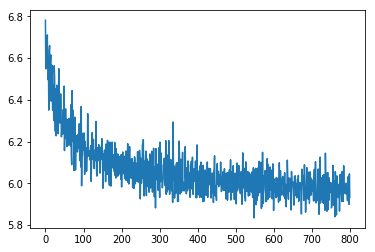

In [0]:
from matplotlib import pyplot as plt 
plt.plot(loss_history)

In [0]:
logits

<tf.Tensor: id=5314249, shape=(1922, 2), dtype=float64, numpy=
array([[-18.754625  ,  -9.72960942],
       [ -7.85124001,   1.40716596],
       [  0.32442173, -10.02176374],
       ...,
       [ -7.84303686, -10.31629043],
       [ -2.44202482,  -6.27930689],
       [ -5.44874876,  -0.37064942]])>

In [0]:
train_y[idx:idx+BATCH_SIZE]

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1])

#concated feature

In [0]:
%%time

import numpy as np

train_feature = []

for i in range(len(train_data_for_bert)):
  app_id = train_data_for_bert["app_id"][i]
  idx_app = train_app[train_app["app_id"] == app_id ].index.values[0]


  parsed = train_data_for_bert["parsed"][i]
  idx_grant = grants[grants["parsed"] == parsed].index.values[0]
  
  f = np.concatenate((train_app_feature[idx_app], grant_feature[idx_grant]), axis=0)
  train_feature.append(f)

CPU times: user 12.6 s, sys: 80.8 ms, total: 12.6 s
Wall time: 12.5 s


In [0]:
train_feature = np.array(train_feature)
train_feature.shape

(7922, 416)

In [0]:
train_x = np.array(train_feature)
train_y = np.array(train_data_for_bert["label"].values.tolist())

In [0]:
%%time

test_feature = []

for i in range(len(dev_data_for_bert)):
  app_id = dev_data_for_bert["app_id"][i]
  idx_app = test_app[test_app["app_id"] == app_id ].index.values[0]


  parsed = dev_data_for_bert["parsed"][i]
  idx_grant = grants[grants["parsed"] == parsed].index.values[0]
  
  f = np.concatenate((test_app_feature[idx_app], grant_feature[idx_grant]), axis=0)
  test_feature.append(f)

CPU times: user 12.2 s, sys: 60.1 ms, total: 12.3 s
Wall time: 12.2 s


In [0]:
test_x = np.array(test_feature)
test_y = np.array(dev_data_for_bert["label"].values.tolist())

In [0]:
import math

class Model(object):
    
  
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.W = tf.Variable( tf.random_normal( [self.input_shape, self.output_shape] ), name='weight' )
        self.variables = [self.W]
    
    def frwrd_pass(self, X_train, Y_train, m = 0.01, s = 64.0):
        cos_m = math.cos(m)
        sin_m = math.sin(m)
        normalized_X_train = tf.nn.l2_normalize(X_train, axis=1)
        normalized_W = tf.nn.l2_normalize(self.W, axis=0)
        
        normalized_X_train = tf.cast(normalized_X_train, tf.double)
        normalized_W = tf.cast(normalized_W, tf.double)
        
        cos_t = tf.matmul( normalized_X_train, normalized_W )
        cos_t2 = tf.square(cos_t, name='cos_2')
        sin_t2 = tf.subtract(1., cos_t2, name='sin_2')
        sin_t = tf.sqrt(sin_t2, name='sin_t')
        cos_mt = s * tf.subtract(tf.multiply(cos_t, cos_m), tf.multiply(sin_t, sin_m), name='cos_mt')
        cos_mt = tf.cast(cos_mt, tf.double)
        
        s_cos_t = tf.multiply(s, cos_t, name='scalar_cos_t')
        s_cos_t = tf.cast(s_cos_t, tf.double)
        
        mask = tf.one_hot(Y_train, depth=2, name='one_hot_mask')
        mask = tf.cast(mask, tf.double)
        inv_mask = tf.subtract(1., mask, name='inverse_mask')
        inv_mask = tf.cast(inv_mask, tf.double)

        output = tf.add(tf.multiply(s_cos_t, inv_mask), tf.multiply(cos_mt, mask), name='arcface_logits')
        
        return output

    def predict(self, X_train, s = 64.0):
        normalized_X_train = tf.nn.l2_normalize(X_train, axis=1)
        normalized_W = tf.nn.l2_normalize(self.W, axis=0)
        
        normalized_X_train = tf.cast(normalized_X_train, tf.double)
        normalized_W = tf.cast(normalized_W, tf.double)
        
        cos_t = tf.matmul( normalized_X_train, normalized_W )
        
        s_cos_t = tf.multiply(s, cos_t, name='scalar_cos_t')
        s_cos_t = tf.cast(s_cos_t, tf.double)        
       
        return s_cos_t

In [0]:
import tensorflow as tf
import tensorflow.contrib.slim as slim

from tqdm import tqdm_notebook as tqdm

In [0]:
loss_history = []

model = Model(input_shape=416, output_shape=2)
EPOCHS = 100
BATCH_SIZE = 1000

for i in tqdm(range(EPOCHS)):
  rnd_idx = np.random.permutation(len(train_x))
  train_x_rnd = train_x[rnd_idx,:]
  train_y_rnd = train_y[rnd_idx]
  for idx in range(0, len(train_x), BATCH_SIZE):
    with tf.GradientTape() as tape:
        logits = model.frwrd_pass(train_x_rnd[idx:idx+BATCH_SIZE], train_y_rnd[idx:idx+BATCH_SIZE])
        logits_2 = model.frwrd_pass(train_x_rnd[idx:idx+BATCH_SIZE], train_y_rnd[idx:idx+BATCH_SIZE], m=0)
        
        loss = slim.losses.sparse_softmax_cross_entropy(logits=logits, labels=train_y_rnd[idx:idx+BATCH_SIZE])
    
    global_step = tf.Variable(0, trainable=False, name='global_step')
    learning_rate = tf.train.exponential_decay(0.01, global_step, EPOCHS, 0.96, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    loss_history.append(loss.numpy())
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables), global_step=global_step)

  logits_rec = model.frwrd_pass(train_x_rnd, train_y_rnd, m=0)
  pred = tf.arg_max(tf.nn.softmax(logits_rec), dimension=-1, output_type=tf.int64)
  train_acc = tf.reduce_mean(tf.cast(tf.equal(pred, train_y_rnd), tf.float32))
  print(train_acc)

tf.Tensor(0.5027771, shape=(), dtype=float32)
tf.Tensor(0.49419338, shape=(), dtype=float32)
tf.Tensor(0.4938147, shape=(), dtype=float32)
tf.Tensor(0.49192125, shape=(), dtype=float32)
tf.Tensor(0.49419338, shape=(), dtype=float32)
tf.Tensor(0.49444586, shape=(), dtype=float32)
tf.Tensor(0.49684423, shape=(), dtype=float32)
tf.Tensor(0.4979803, shape=(), dtype=float32)
tf.Tensor(0.49886394, shape=(), dtype=float32)
tf.Tensor(0.4974754, shape=(), dtype=float32)
tf.Tensor(0.50138855, shape=(), dtype=float32)
tf.Tensor(0.49848524, shape=(), dtype=float32)
tf.Tensor(0.49785408, shape=(), dtype=float32)
tf.Tensor(0.5066902, shape=(), dtype=float32)
tf.Tensor(0.50858366, shape=(), dtype=float32)
tf.Tensor(0.5078263, shape=(), dtype=float32)
tf.Tensor(0.50959355, shape=(), dtype=float32)
tf.Tensor(0.5087099, shape=(), dtype=float32)
tf.Tensor(0.50807875, shape=(), dtype=float32)
tf.Tensor(0.5078263, shape=(), dtype=float32)
tf.Tensor(0.5084575, shape=(), dtype=float32)
tf.Tensor(0.50681645, 

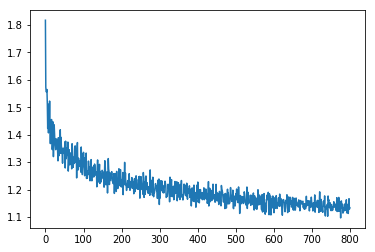

In [0]:
from matplotlib import pyplot as plt 
plt.plot(loss_history)

In [0]:
logits_pred = model.predict(test_x)
pred = tf.arg_max(tf.nn.softmax(logits_pred), dimension=-1, output_type=tf.int64)
test_acc = tf.reduce_mean(tf.cast(tf.equal(pred, test_y), tf.float32))
print(test_acc.numpy())

0.50802547


#same as the original 

In [0]:
import math

class Model(object):
    
  
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.W = tf.Variable( tf.random_normal( [self.input_shape, self.output_shape] ), name='weight' )
        self.variables = [self.W]
    
    def frwrd_pass(self, X_train, Y_train, m = 0.1, s = 64.0):
        cos_m = math.cos(m)
        sin_m = math.sin(m)    
        
        mm = sin_m * m
        threshold = math.cos(math.pi - m)
    
        normalized_X_train = tf.nn.l2_normalize(X_train, axis=1)
        normalized_W = tf.nn.l2_normalize(self.W, axis=0)
        
        normalized_X_train = tf.cast(normalized_X_train, tf.double)
        normalized_W = tf.cast(normalized_W, tf.double)
        
        cos_t = tf.matmul( normalized_X_train, normalized_W )
        cos_t2 = tf.square(cos_t, name='cos_2')
        sin_t2 = tf.subtract(1., cos_t2, name='sin_2')
        sin_t = tf.sqrt(sin_t2, name='sin_t')
        cos_mt = s * tf.subtract(tf.multiply(cos_t, cos_m), tf.multiply(sin_t, sin_m), name='cos_mt')
        cos_mt = tf.cast(cos_mt, tf.double)
        
        s_cos_t = tf.multiply(s, cos_t, name='scalar_cos_t')
        s_cos_t = tf.cast(s_cos_t, tf.double)
        
        cond_v = cos_t - threshold
        cond = tf.cast(tf.nn.relu(cond_v, name='if_else'), dtype=tf.bool)
        keep_val = s*(cos_t - mm)
        cos_mt_temp = tf.where(cond, cos_mt, keep_val)
        
        mask = tf.one_hot(Y_train, depth=2, name='one_hot_mask')
        mask = tf.cast(mask, tf.double)
        inv_mask = tf.subtract(1., mask, name='inverse_mask')
        inv_mask = tf.cast(inv_mask, tf.double)

        output = tf.add(tf.multiply(s_cos_t, inv_mask), tf.multiply(cos_mt_temp, mask), name='arcface_logits')
        
        return output

    def predict(self, X_train, s = 64.0):
        normalized_X_train = tf.nn.l2_normalize(X_train, axis=1)
        normalized_W = tf.nn.l2_normalize(self.W, axis=0)
        
        normalized_X_train = tf.cast(normalized_X_train, tf.double)
        normalized_W = tf.cast(normalized_W, tf.double)
        
        cos_t = tf.matmul( normalized_X_train, normalized_W )
        
        s_cos_t = tf.multiply(s, cos_t, name='scalar_cos_t')
        s_cos_t = tf.cast(s_cos_t, tf.double)        
       
        return s_cos_t

In [0]:
import tensorflow as tf
import tensorflow.contrib.slim as slim

from tqdm import tqdm_notebook as tqdm

In [0]:
loss_history = []

model = Model(input_shape=416, output_shape=2)
EPOCHS = 100
BATCH_SIZE = 1000

for i in tqdm(range(EPOCHS)):
  rnd_idx = np.random.permutation(len(train_x))
  train_x_rnd = train_x[rnd_idx,:]
  train_y_rnd = train_y[rnd_idx]
  for idx in range(0, len(train_x), BATCH_SIZE):
    with tf.GradientTape() as tape:
        logits = model.frwrd_pass(train_x_rnd[idx:idx+BATCH_SIZE], train_y_rnd[idx:idx+BATCH_SIZE])
        logits_2 = model.frwrd_pass(train_x_rnd[idx:idx+BATCH_SIZE], train_y_rnd[idx:idx+BATCH_SIZE], m=0)
        
        loss = slim.losses.sparse_softmax_cross_entropy(logits=logits, labels=train_y_rnd[idx:idx+BATCH_SIZE])
    
    global_step = tf.Variable(0, trainable=False, name='global_step')
    learning_rate = tf.train.exponential_decay(0.01, global_step, EPOCHS, 0.96, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    loss_history.append(loss.numpy())
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables), global_step=global_step)

  logits_rec = model.frwrd_pass(train_x_rnd, train_y_rnd, m=0)
  pred = tf.arg_max(tf.nn.softmax(logits_rec), dimension=-1, output_type=tf.int64)
  train_acc = tf.reduce_mean(tf.cast(tf.equal(pred, train_y_rnd), tf.float32))
  print(train_acc)

tf.Tensor(0.5071952, shape=(), dtype=float32)
tf.Tensor(0.5056804, shape=(), dtype=float32)
tf.Tensor(0.49785408, shape=(), dtype=float32)
tf.Tensor(0.50467056, shape=(), dtype=float32)
tf.Tensor(0.50833124, shape=(), dtype=float32)
tf.Tensor(0.5056804, shape=(), dtype=float32)
tf.Tensor(0.5066902, shape=(), dtype=float32)
tf.Tensor(0.5054279, shape=(), dtype=float32)
tf.Tensor(0.5020197, shape=(), dtype=float32)
tf.Tensor(0.5017672, shape=(), dtype=float32)
tf.Tensor(0.5040394, shape=(), dtype=float32)
tf.Tensor(0.5064378, shape=(), dtype=float32)
tf.Tensor(0.501641, shape=(), dtype=float32)
tf.Tensor(0.4994951, shape=(), dtype=float32)
tf.Tensor(0.50265086, shape=(), dtype=float32)
tf.Tensor(0.4996213, shape=(), dtype=float32)
tf.Tensor(0.4994951, shape=(), dtype=float32)
tf.Tensor(0.5064378, shape=(), dtype=float32)
tf.Tensor(0.49684423, shape=(), dtype=float32)
tf.Tensor(0.5005049, shape=(), dtype=float32)
tf.Tensor(0.5077001, shape=(), dtype=float32)
tf.Tensor(0.5037869, shape=(),

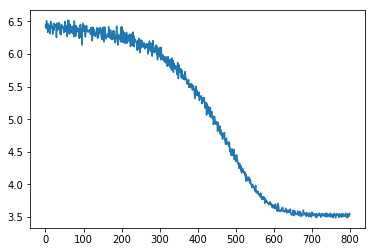

In [0]:
from matplotlib import pyplot as plt 
plt.plot(loss_history)

In [0]:
logits_pred = model.predict(test_x)
pred = tf.arg_max(tf.nn.softmax(logits_pred), dimension=-1, output_type=tf.int64)
test_acc = tf.reduce_mean(tf.cast(tf.equal(pred, test_y), tf.float32))
print(test_acc.numpy())

0.48203823


#trial and error

In [0]:
import math

class Model_2(object):
    
  
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
        intermediate_shape=50
        self.W1 = tf.Variable( tf.random_normal( [self.input_shape, intermediate_shape] ), name='weight' )
        self.W2 = tf.Variable( tf.random_normal( [intermediate_shape, self.output_shape] ), name='weight' )
        self.variables = [self.W1, self.W2]
    
    def frwrd_pass(self, X_train, Y_train, m = 0.01, s = 64.0):
        cos_m = math.cos(m)
        sin_m = math.sin(m)
        
        X_train = tf.cast(X_train, tf.double)
        self.W1 = tf.cast(self.W1, tf.double)
                
        intermediate = tf.matmul( X_train, self.W1 )
        normalized_intermediate = tf.nn.l2_normalize(intermediate, axis=1)
        normalized_W2 = tf.nn.l2_normalize(self.W2, axis=0)
        
        normalized_intermediate = tf.cast(normalized_intermediate, tf.double)
        normalized_W2 = tf.cast(normalized_W2, tf.double)
        
        cos_t = tf.matmul( normalized_intermediate, normalized_W2 )
        cos_t2 = tf.square(cos_t, name='cos_2')
        sin_t2 = tf.subtract(1., cos_t2, name='sin_2')
        sin_t = tf.sqrt(sin_t2, name='sin_t')
        cos_mt = s * tf.subtract(tf.multiply(cos_t, cos_m), tf.multiply(sin_t, sin_m), name='cos_mt')
        cos_mt = tf.cast(cos_mt, tf.double)
        
        s_cos_t = tf.multiply(s, cos_t, name='scalar_cos_t')
        s_cos_t = tf.cast(s_cos_t, tf.double)
        
        mask = tf.one_hot(Y_train, depth=2, name='one_hot_mask')
        mask = tf.cast(mask, tf.double)
        inv_mask = tf.subtract(1., mask, name='inverse_mask')
        inv_mask = tf.cast(inv_mask, tf.double)

        output = tf.add(tf.multiply(s_cos_t, inv_mask), tf.multiply(cos_mt, mask), name='arcface_logits')
        
        return output

    def predict(self, X_train, s = 64.0):
        intermediate = tf.matmul( X_train, self.W1 )
        normalized_intermediate = tf.nn.l2_normalize(intermediate, axis=1)
        normalized_W2 = tf.nn.l2_normalize(self.W2, axis=0)
        
        normalized_intermediate = tf.cast(normalized_intermediate, tf.double)
        normalized_W2 = tf.cast(normalized_W2, tf.double)
        
        cos_t = tf.matmul( normalized_intermediate, normalized_W2 )
        
        s_cos_t = tf.multiply(s, cos_t, name='scalar_cos_t')
        s_cos_t = tf.cast(s_cos_t, tf.double)        
       
        return s_cos_t

In [0]:
loss_history = []

model = Model_2(input_shape=416, output_shape=2)
EPOCHS = 100
BATCH_SIZE = 1000

for i in tqdm(range(EPOCHS)):
  rnd_idx = np.random.permutation(len(train_x))
  train_x_rnd = train_x[rnd_idx,:]
  train_y_rnd = train_y[rnd_idx]
  for idx in range(0, len(train_x), BATCH_SIZE):
    with tf.GradientTape() as tape:
        logits = model.frwrd_pass(train_x_rnd[idx:idx+BATCH_SIZE], train_y_rnd[idx:idx+BATCH_SIZE])
        
        loss = slim.losses.sparse_softmax_cross_entropy(logits=logits, labels=train_y_rnd[idx:idx+BATCH_SIZE])
    
    global_step = tf.Variable(0, trainable=False, name='global_step')
    learning_rate = tf.train.exponential_decay(0.01, global_step, EPOCHS, 0.96, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    loss_history.append(loss.numpy())
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables), global_step=global_step)

  logits_rec = model.frwrd_pass(train_x_rnd, train_y_rnd, m=0)
  pred = tf.arg_max(tf.nn.softmax(logits_rec), dimension=-1, output_type=tf.int64)
  train_acc = tf.reduce_mean(tf.cast(tf.equal(pred, train_y_rnd), tf.float32))
  print(train_acc)

tf.Tensor(0.50757384, shape=(), dtype=float32)
tf.Tensor(0.5079525, shape=(), dtype=float32)
tf.Tensor(0.5071952, shape=(), dtype=float32)
tf.Tensor(0.5044181, shape=(), dtype=float32)
tf.Tensor(0.50479674, shape=(), dtype=float32)
tf.Tensor(0.5071952, shape=(), dtype=float32)
tf.Tensor(0.50858366, shape=(), dtype=float32)
tf.Tensor(0.5050492, shape=(), dtype=float32)
tf.Tensor(0.50681645, shape=(), dtype=float32)
tf.Tensor(0.50467056, shape=(), dtype=float32)
tf.Tensor(0.5044181, shape=(), dtype=float32)
tf.Tensor(0.5053017, shape=(), dtype=float32)
tf.Tensor(0.50214595, shape=(), dtype=float32)
tf.Tensor(0.5087099, shape=(), dtype=float32)
tf.Tensor(0.50214595, shape=(), dtype=float32)
tf.Tensor(0.50429183, shape=(), dtype=float32)
tf.Tensor(0.5015148, shape=(), dtype=float32)
tf.Tensor(0.50479674, shape=(), dtype=float32)
tf.Tensor(0.5122444, shape=(), dtype=float32)
tf.Tensor(0.5074476, shape=(), dtype=float32)
tf.Tensor(0.51173943, shape=(), dtype=float32)
tf.Tensor(0.509846, shap

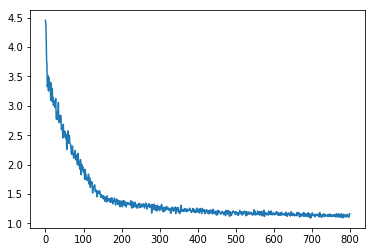

In [0]:
from matplotlib import pyplot as plt 
plt.plot(loss_history)

In [0]:
logits_pred = model.predict(test_x)
pred = tf.arg_max(tf.nn.softmax(logits_pred), dimension=-1, output_type=tf.int64)
test_acc = tf.reduce_mean(tf.cast(tf.equal(pred, test_y), tf.float32))
print(test_acc.numpy())

0.50254774


In [0]:
%%time

train_app_x = []
train_grant_x = []

for i in range(len(train_data_for_bert)):
  app_id = train_data_for_bert["app_id"][i]
  idx_app = train_app[train_app["app_id"] == app_id ].index.values[0]

  parsed = train_data_for_bert["parsed"][i]
  idx_grant = grants[grants["parsed"] == parsed].index.values[0] 
  
  f1 = train_app_feature[idx_app]
  f2 = grant_feature[idx_grant]
  
  train_app_x.append(f1)
  train_grant_x.append(f2)  

CPU times: user 14.9 s, sys: 131 ms, total: 15 s
Wall time: 14.9 s


In [0]:
import numpy as np

train_app_x = np.array(train_app_x)
train_grant_x = np.array(train_grant_x)

train_y = np.array(train_data_for_bert["label"].values.tolist())

In [0]:
%%time

test_app_x = []
test_grant_x = []

for i in range(len(dev_data_for_bert)):
  app_id = dev_data_for_bert["app_id"][i]
  idx_app = test_app[test_app["app_id"] == app_id ].index.values[0]

  parsed = dev_data_for_bert["parsed"][i]
  idx_grant = grants[grants["parsed"] == parsed].index.values[0]
  
  f1 = test_app_feature[idx_app] 
  f2 = grant_feature[idx_grant]
  
  test_app_x.append(f1)
  test_grant_x.append(f2)

CPU times: user 14.6 s, sys: 55.3 ms, total: 14.7 s
Wall time: 14.6 s


In [0]:
test_app_x = np.array(test_app_x)
test_grant_x = np.array(test_grant_x)

test_y = np.array(dev_data_for_bert["label"].values.tolist())

In [0]:
train_app_x.shape, train_grant_x.shape

((7922, 208), (7922, 208))

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.contrib.slim as slim

from tqdm import tqdm_notebook as tqdm

tf.enable_eager_execution()

In [0]:
import math

class Model_3(object):
    
  
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.W1 = tf.Variable( tf.random_normal( [self.input_shape, self.input_shape] ), name='weight' )
        self.W2 = tf.Variable( tf.random_normal( [self.input_shape, self.input_shape] ), name='weight' )
        self.variables = [self.W1, self.W2]
    
    def frwrd_pass(self, X_app, X_grant, Y_train, m = 0.1, s = 32.0):
        cos_m = math.cos(m)
        sin_m = math.sin(m)
        normalized_X_app = tf.nn.l2_normalize(X_app, axis=1)
        normalized_X_grant = tf.nn.l2_normalize(X_grant, axis=1)
        
        normalized_W1 = tf.nn.l2_normalize(self.W1, axis=0)
        normalized_W1 = tf.nn.l2_normalize(normalized_W1, axis=1)
        
        normalized_W2 = tf.nn.l2_normalize(self.W2, axis=0)
        normalized_W2 = tf.nn.l2_normalize(normalized_W2, axis=1)

        normalized_X_app = tf.cast(normalized_X_app, tf.double)
        normalized_X_grant = tf.cast(normalized_X_grant, tf.double)
        normalized_W1 = tf.cast(normalized_W1, tf.double)        
        normalized_W2 = tf.cast(normalized_W2, tf.double)        
        
        prod_1 = tf.reduce_sum(tf.matmul( normalized_X_app, normalized_W1 )*normalized_X_grant, axis=1)
        prod_2 = tf.reduce_sum(tf.matmul( normalized_X_app, normalized_W2 )*normalized_X_grant, axis=1)       
               
        cos_t = tf.stack([prod_1,prod_2], 1)

        cos_t2 = tf.square(cos_t, name='cos_2')
        sin_t2 = tf.subtract(1., cos_t2, name='sin_2')
        sin_t = tf.sqrt(sin_t2, name='sin_t')
        cos_mt = s * tf.subtract(tf.multiply(cos_t, cos_m), tf.multiply(sin_t, sin_m), name='cos_mt')
        cos_mt = tf.cast(cos_mt, tf.double)
        
        s_cos_t = tf.multiply(s, cos_t, name='scalar_cos_t')
        s_cos_t = tf.cast(s_cos_t, tf.double)
        
        mask = tf.one_hot(Y_train, depth=2, name='one_hot_mask')
        mask = tf.cast(mask, tf.double)
        inv_mask = tf.subtract(1., mask, name='inverse_mask')
        inv_mask = tf.cast(inv_mask, tf.double)

        output = tf.add(tf.multiply(s_cos_t, inv_mask), tf.multiply(cos_mt, mask), name='arcface_logits')
        
        return output
      
    def predict(self, X_app, X_grant, s = 32.0):
        normalized_X_app = tf.nn.l2_normalize(X_app, axis=1)
        normalized_X_grant = tf.nn.l2_normalize(X_grant, axis=1)
        
        normalized_W1 = tf.nn.l2_normalize(self.W1, axis=0)
        normalized_W1 = tf.nn.l2_normalize(normalized_W1, axis=1)
        
        normalized_W2 = tf.nn.l2_normalize(self.W2, axis=0)
        normalized_W2 = tf.nn.l2_normalize(normalized_W2, axis=1)

        normalized_X_app = tf.cast(normalized_X_app, tf.double)
        normalized_X_grant = tf.cast(normalized_X_grant, tf.double)
        normalized_W1 = tf.cast(normalized_W1, tf.double)        
        normalized_W2 = tf.cast(normalized_W2, tf.double)        
        
        prod_1 = tf.reduce_sum(tf.matmul( normalized_X_app, normalized_W1 )*normalized_X_grant, axis=1)
        prod_2 = tf.reduce_sum(tf.matmul( normalized_X_app, normalized_W2 )*normalized_X_grant, axis=1)       
                    
        cos_t = tf.stack([prod_1, prod_2], 1)
        
        s_cos_t = tf.multiply(s, cos_t, name='scalar_cos_t')
        s_cos_t = tf.cast(s_cos_t, tf.double)        
       
        return s_cos_t

In [0]:
loss_history = []

model = Model_3(input_shape=208)
EPOCHS = 30
BATCH_SIZE = 500

for i in tqdm(range(EPOCHS)):
  rnd_idx = np.random.permutation(len(train_app_x))
  train_app_x_rnd = train_app_x[rnd_idx,:]
  train_grant_x_rnd = train_grant_x[rnd_idx,:]
  train_y_rnd = train_y[rnd_idx]
  for idx in range(0, len(train_app_x), BATCH_SIZE):
    with tf.GradientTape() as tape:
        logits = model.frwrd_pass(train_app_x_rnd[idx:idx+BATCH_SIZE], train_grant_x_rnd[idx:idx+BATCH_SIZE], train_y_rnd[idx:idx+BATCH_SIZE])
        
#         loss = slim.losses.sparse_softmax_cross_entropy(logits=logits, labels=train_y_rnd[idx:idx+BATCH_SIZE])
        loss = slim.losses.sparse_softmax_cross_entropy(logits=logits, labels=train_y_rnd[idx:idx+BATCH_SIZE]) - tf.minimum( tf.reduce_min( tf.cast(model.W1, tf.double)),0) - tf.minimum( tf.reduce_min( tf.cast(model.W2, tf.double)),0)
  
    global_step = tf.Variable(0, trainable=False, name='global_step')
    learning_rate = tf.train.exponential_decay(0.01, global_step, EPOCHS, 0.96, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    loss_history.append(loss.numpy())
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables), global_step=global_step)

  logits_rec = model.frwrd_pass(train_app_x_rnd, train_grant_x_rnd, train_y_rnd, m=0)
  pred = tf.arg_max(tf.nn.softmax(logits_rec), dimension=-1, output_type=tf.int64)
  train_acc = tf.reduce_mean(tf.cast(tf.equal(pred, train_y_rnd), tf.float32))
  print(train_acc.numpy())

0.6956577
0.7557435
0.7790962
0.791593
0.80194396
0.8097703
0.81633425
0.82239336
0.827695
0.83728856
0.83930826
0.8427165
0.84334767
0.8451149
0.8501641
0.85231
0.8510477
0.85546577
0.855592
0.8591265
0.86240846
0.8645544
0.8658167
0.86442816
0.8685938
0.8714971
0.87238073
0.8745266
0.8745266
0.8756627


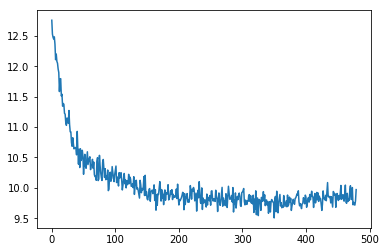

In [0]:
from matplotlib import pyplot as plt 
plt.plot(loss_history)

In [0]:
logits_pred = model.predict(test_app_x, test_grant_x)
pred = tf.arg_max(tf.nn.softmax(logits_pred), dimension=-1, output_type=tf.int64)
test_acc = tf.reduce_mean(tf.cast(tf.equal(pred, test_y), tf.float32))
print(test_acc.numpy())

0.85388535


In [0]:
import math

class Model_4(object):
    
  
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.W1 = tf.Variable( tf.add(np.identity(self.input_shape), tf.random.normal([self.input_shape, self.input_shape], mean=0.0, stddev=0.5 )))
        self.W2 = tf.Variable( tf.add(np.identity(self.input_shape), tf.random.normal([self.input_shape, self.input_shape], mean=0.0, stddev=0.5 )))
        self.variables = [self.W1, self.W2]
    
    def frwrd_pass(self, X_app, X_grant, Y_train, m = 0.1, s = 32.0):
        normalized_X_app = tf.nn.l2_normalize(X_app, axis=1)
        normalized_X_grant = tf.nn.l2_normalize(X_grant, axis=1)
        
        abs_W1 = tf.abs(self.W1)
        normalized_W1 = tf.nn.l2_normalize(abs_W1, axis=0)
        normalized_W1 = tf.nn.l2_normalize(normalized_W1, axis=1)
        
        abs_W2 = tf.abs(self.W2)
        normalized_W2 = tf.nn.l2_normalize(abs_W2, axis=0)
        normalized_W2 = tf.nn.l2_normalize(normalized_W2, axis=1)

        normalized_X_app = tf.cast(normalized_X_app, tf.double)
        normalized_X_grant = tf.cast(normalized_X_grant, tf.double)
        normalized_W1 = tf.cast(normalized_W1, tf.double)        
        normalized_W2 = tf.cast(normalized_W2, tf.double)     
        
        prod_1 = tf.reduce_sum(tf.matmul( normalized_X_app, normalized_W1 )*normalized_X_grant, axis=1)
        prod_2 = tf.reduce_sum(tf.matmul( normalized_X_app, normalized_W2 )*normalized_X_grant, axis=1)       
               
        cos_t = tf.stack([prod_1,prod_2], 1)
        
        angle = tf.acos(cos_t)
        angle_m = tf.add(angle, m)
        
        s_angle = tf.multiply(s, angle)
        s_angle = tf.cast(s_angle, tf.double)
        s_angle_m = tf.multiply(s, angle_m)
        s_angle_m = tf.cast(s_angle_m, tf.double)
        
        mask = tf.one_hot(Y_train, depth=2, name='one_hot_mask')
        mask = tf.cast(mask, tf.double)
        inv_mask = tf.subtract(1., mask, name='inverse_mask')
        inv_mask = tf.cast(inv_mask, tf.double)

        output = tf.add(tf.multiply(s_angle, inv_mask), tf.multiply(s_angle_m, mask))
        
        return output
      
    def predict(self, X_app, X_grant, s = 32.0):
        normalized_X_app = tf.nn.l2_normalize(X_app, axis=1)
        normalized_X_grant = tf.nn.l2_normalize(X_grant, axis=1)
        
        abs_W1 = tf.abs(self.W1)
        normalized_W1 = tf.nn.l2_normalize(abs_W1, axis=0)
        normalized_W1 = tf.nn.l2_normalize(normalized_W1, axis=1)
        
        abs_W2 = tf.abs(self.W2)
        normalized_W2 = tf.nn.l2_normalize(abs_W2, axis=0)
        normalized_W2 = tf.nn.l2_normalize(normalized_W2, axis=1)

        normalized_X_app = tf.cast(normalized_X_app, tf.double)
        normalized_X_grant = tf.cast(normalized_X_grant, tf.double)
        normalized_W1 = tf.cast(normalized_W1, tf.double)        
        normalized_W2 = tf.cast(normalized_W2, tf.double)        
        
        prod_1 = tf.reduce_sum(tf.matmul( normalized_X_app, normalized_W1 )*normalized_X_grant, axis=1)
        prod_2 = tf.reduce_sum(tf.matmul( normalized_X_app, normalized_W2 )*normalized_X_grant, axis=1)       
                    
        cos_t = tf.stack([prod_1,prod_2], 1)
        
        angle = tf.acos(cos_t)
        
        s_angle = tf.multiply(s, angle)
        s_angle = tf.cast(s_angle, tf.double)
                
        return s_angle

In [0]:
loss_history = []

model = Model_4(input_shape=208)
EPOCHS = 50
BATCH_SIZE = 1000

for i in tqdm(range(EPOCHS)):
  rnd_idx = np.random.permutation(len(train_app_x))
  train_app_x_rnd = train_app_x[rnd_idx,:]
  train_grant_x_rnd = train_grant_x[rnd_idx,:]
  train_y_rnd = train_y[rnd_idx]
  for idx in range(0, len(train_app_x), BATCH_SIZE):
    with tf.GradientTape() as tape:
        logits = model.frwrd_pass(train_app_x_rnd[idx:idx+BATCH_SIZE], train_grant_x_rnd[idx:idx+BATCH_SIZE], train_y_rnd[idx:idx+BATCH_SIZE])
        
        loss = slim.losses.sparse_softmax_cross_entropy(logits=logits, labels=train_y_rnd[idx:idx+BATCH_SIZE])
  
    global_step = tf.Variable(0, trainable=False, name='global_step')
    learning_rate = tf.train.exponential_decay(0.01, global_step, EPOCHS, 0.96, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    loss_history.append(loss.numpy())
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables), global_step=global_step)

  logits_rec = model.frwrd_pass(train_app_x_rnd, train_grant_x_rnd, train_y_rnd, m=0)
  pred = tf.arg_max(tf.nn.softmax(logits_rec), dimension=-1, output_type=tf.int64)
  train_acc = tf.reduce_mean(tf.cast(tf.equal(pred, train_y_rnd), tf.float32))
  print(train_acc.numpy())

0.5099722
0.51451653
0.5184297
0.5220904
0.5273921
0.5337036
0.53875285
0.5417824
0.54910374
0.55036604
0.55263823
0.5562989
0.55894977
0.56134814
0.5627367
0.5650088
0.56955314
0.5737188
0.577127
0.58028275
0.5811664
0.5826811
0.5865943
0.5887402
0.59025496
0.59151727
0.5931583
0.5947993
0.59505177
0.59795505
0.5988387
0.60022724
0.60199445
0.6042666
0.60401416
0.603383
0.605024
0.60641253
0.608306
0.6090634
0.613229
0.6128503
0.6100732
0.6129765
0.60918957
0.6105781
0.61348146
0.61474377
0.61512244
0.6175208


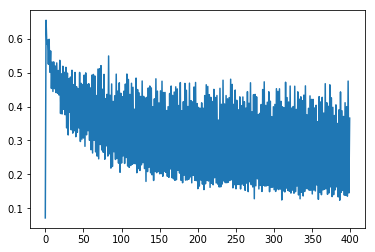

In [0]:
from matplotlib import pyplot as plt 
plt.plot(loss_history)

In [0]:
logits_pred = model.predict(test_app_x, test_grant_x)
pred = tf.arg_max(tf.nn.softmax(logits_pred), dimension=-1, output_type=tf.int64)
test_acc = tf.reduce_mean(tf.cast(tf.equal(pred, test_y), tf.float32))
print(test_acc.numpy())

0.6019108


In [0]:
abs_W1 = tf.abs(model.W1)
normalized_W1 = tf.nn.l2_normalize(abs_W1, axis=0)
normalized_W1 = tf.nn.l2_normalize(normalized_W1, axis=1)
normalized_W1.numpy()[0]

array([1.13911286e-01, 1.06234223e-01, 9.18433592e-02, 5.79559244e-02,
       7.32772872e-02, 8.89409408e-02, 4.68945084e-03, 4.86757420e-02,
       1.20901437e-02, 7.25728795e-02, 5.18694706e-02, 1.77925620e-02,
       4.65760306e-02, 2.72024926e-02, 7.17295930e-02, 1.02174520e-01,
       8.83000642e-02, 6.39180019e-02, 7.87479430e-02, 1.76985729e-02,
       2.80778483e-02, 3.00971251e-02, 8.23758096e-02, 6.83889026e-03,
       8.79132375e-02, 1.56910047e-01, 2.10160241e-02, 9.34262127e-02,
       6.76360428e-02, 1.25688046e-01, 3.09544429e-02, 3.01402714e-02,
       3.45848091e-02, 1.10518433e-01, 1.59933925e-01, 6.60480931e-02,
       3.28430161e-02, 8.95748436e-02, 3.21349339e-03, 1.89014580e-02,
       1.34847946e-02, 2.18260288e-02, 2.11343039e-02, 3.34715098e-02,
       2.55234744e-02, 6.32369891e-02, 3.96823362e-02, 7.80824497e-02,
       3.18861306e-02, 9.48318373e-03, 2.26867795e-02, 3.41301635e-02,
       1.04420908e-01, 1.06268199e-02, 4.48979065e-02, 1.75139494e-02,
      

In [0]:
import math

class Model_5(object):
    
  
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.W = tf.Variable( np.identity(self.input_shape))
        self.variables = [self.W]
    
    def frwrd_pass(self, X_app, X_grant, Y_train, m = 0.1, s = 1.0):
        normalized_X_app = tf.nn.l2_normalize(X_app, axis=1)
        normalized_X_grant = tf.nn.l2_normalize(X_grant, axis=1)       
       
        normalized_X_app = tf.cast(normalized_X_app, tf.double)
        normalized_X_grant = tf.cast(normalized_X_grant, tf.double)
        W = tf.cast(self.W, tf.double)        
        
        cos_t = tf.reduce_sum(tf.matmul( normalized_X_app, W )*normalized_X_grant, axis=1)        
        
        cos_t_minus = tf.subtract(cos_t, m)
        s_cos_t_minus = tf.multiply(s, cos_t_minus)
        s_cos_t_minus = tf.cast(s_cos_t_minus, tf.double)
        
        cos_t_plus = tf.add(cos_t, m)
        s_cos_t_plus = tf.multiply(s, cos_t_plus)
        s_cos_t_plus = tf.cast(s_cos_t_plus, tf.double)            

        output = tf.where(Y_train, s_cos_t_minus, s_cos_t_plus)

        return output
      
    def predict(self, X_app, X_grant, s = 1.0):
        normalized_X_app = tf.nn.l2_normalize(X_app, axis=1)
        normalized_X_grant = tf.nn.l2_normalize(X_grant, axis=1)
        
        normalized_X_app = tf.cast(normalized_X_app, tf.double)
        normalized_X_grant = tf.cast(normalized_X_grant, tf.double)
        W = tf.cast(self.W, tf.double)            
        
        cos_t = tf.reduce_sum(tf.matmul( normalized_X_app, W )*normalized_X_grant, axis=1)
        s_cos_t = tf.multiply(s, cos_t)
        s_cos_t = tf.cast(s_cos_t, tf.double)     
                
        return s_cos_t

In [0]:
loss_history = []

model = Model_5(input_shape=208)
EPOCHS = 100
BATCH_SIZE = 500

for i in tqdm(range(EPOCHS)):
  rnd_idx = np.random.permutation(len(train_app_x))
  train_app_x_rnd = train_app_x[rnd_idx,:]
  train_grant_x_rnd = train_grant_x[rnd_idx,:]
  train_y_rnd = train_y[rnd_idx]
  for idx in range(0, len(train_app_x), BATCH_SIZE):
    with tf.GradientTape() as tape:
        logits = model.frwrd_pass(train_app_x_rnd[idx:idx+BATCH_SIZE], train_grant_x_rnd[idx:idx+BATCH_SIZE], train_y_rnd[idx:idx+BATCH_SIZE])

        loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=train_y_rnd[idx:idx+BATCH_SIZE].astype(np.double))
  
    global_step = tf.Variable(0, trainable=False, name='global_step')
    learning_rate = tf.train.exponential_decay(0.01, global_step, EPOCHS, 0.96, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    loss_history.append(loss.numpy())
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables), global_step=global_step)

  logits_rec = model.frwrd_pass(train_app_x_rnd, train_grant_x_rnd, train_y_rnd, m=0)
  pred = tf.nn.sigmoid(logits_rec).numpy()
  prediction = [ 1 if elem >= 0.5 else 0 for elem in pred]
  train_acc = tf.reduce_mean(tf.cast(tf.equal(prediction, train_y_rnd), tf.float32))
  print(train_acc.numpy())

0.7458975
0.7987882
0.8146933
0.8287049
0.83110327
0.8403181
0.85193133
0.85571826
0.8608937
0.86240846
0.8674577
0.8707397
0.88311034
0.8812169
0.8791972
0.880207
0.88336277
0.88891697
0.8894219
0.89585966
0.89257765
0.89459735
0.8986367
0.8976269
0.90254986
0.89952034
0.90204495
0.8962383
0.90254986
0.9022974
0.90406466
0.90924007
0.9058319
0.90823025
0.9072204
0.90898764
0.9098712
0.9117647
0.9118909
0.91845495
0.9154254
0.9199697
0.91795003
0.9166877
0.91769755
0.919591
0.9200959
0.91921234
0.9224943
0.92224187
0.9221156
0.92388284
0.9267862
0.9240091
0.92665994
0.9283009
0.92665994
0.9283009
0.92691237
0.9290583
0.9351174
0.92994195
0.9322141
0.93335015
0.93208784
0.93486494
0.9317092
0.9347387
0.9354961
0.9351174
0.93663216
0.93461245
0.93562233
0.9349912
0.9352436
0.9370109
0.93814695
0.936001
0.939283
0.93865186
0.9383994
0.93865186
0.95127493
0.9516536
0.9520323
0.9421863
0.9416814
0.94357485
0.94029284
0.940924
0.9400404
0.9503913
0.949129
0.9424388
0.94433224
0.94269127
0.94

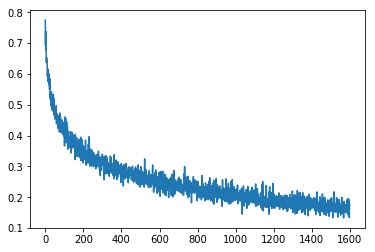

In [0]:
from matplotlib import pyplot as plt 
plt.plot([np.average(loss) for loss in loss_history] )

In [0]:
logits_pred = model.predict(test_app_x, test_grant_x)
pred = tf.nn.sigmoid(logits_pred).numpy()
prediction = [ 1 if elem >= 0.5 else 0 for elem in pred]
test_acc = np.average([1 if p == l else 0 for p,l in zip(prediction, test_y)])
print(test_acc)

0.9135031847133758


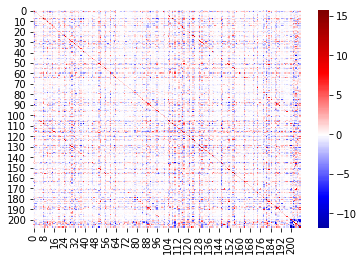

In [0]:
import seaborn as sns

sns.heatmap(model.W.numpy(), center=0, cmap='seismic')

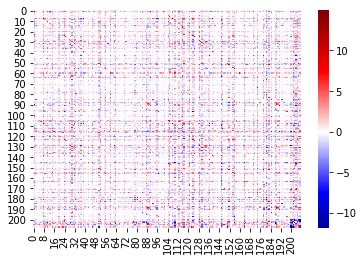

In [0]:
 sns.heatmap(model.W.numpy() - np.identity(208), center=0, cmap='seismic')

In [0]:
def copy_app(one_app_f):
  
  length = math.ceil(math.log2(len(grant_feature)))

  for i in range(length):
    one_app_f = np.vstack((one_app_f,one_app_f))

  one_test_f = one_app_f[0:len(grant_feature)]

  return one_test_f

In [0]:
%%time

predict_prob=[]
 
for i, one_app in enumerate(test_app_feature):
  list = model.predict(copy_app(one_app), grant_feature).numpy()
  predict_prob.append(list)
  if i % 1000 ==0: print(i)

0


KeyboardInterrupt: ignored

In [0]:
%%time

predict_prob=[]
 
for i, one_app in enumerate(test_app_feature):
  list = model.predict(copy_app(one_app), grant_feature).numpy()
  pred = tf.nn.sigmoid(list).numpy()
  predict_prob.append(pred)
  if i % 1000 ==0: print(i)

0
1000
2000
CPU times: user 48.6 s, sys: 6.6 s, total: 55.2 s
Wall time: 57.3 s


In [0]:
import pickle
import gzip

filename = "predict_prob_with_modified_ArcFace.pkl.gz"

with gzip.open(filename, 'w') as f:
  pickle.dump(predict_prob, f)

!gsutil cp {filename} gs://mlstudy-phys/data/results/

In [0]:
import gzip
import pickle

filename = "predict_prob_with_modified_ArcFace.pkl.gz"

!gsutil cp gs://mlstudy-phys/data/results/{filename} ./

with gzip.open(filename, 'rb') as f:
  predict_prob = pickle.load(f)

Copying gs://mlstudy-phys/data/results/predict_prob_with_modified_ArcFace.pkl.gz...
- [1 files][284.6 MiB/284.6 MiB]                                                
Operation completed over 1 objects/284.6 MiB.                                    


In [0]:
predict_prob = np.array(predict_prob)
predict_prob.shape

(3000, 6440)

In [0]:
predict = tf.nn.softmax(predict_prob)
predict = predict.numpy()
predict = predict[:,:,1]
predict.shape

(3000, 6440)

In [0]:
predict[0,0:10]

array([9.92878610e-01, 2.31660558e-06, 4.09528662e-06, 1.87827094e-03,
       1.38316634e-03, 2.55436186e-06, 1.20642260e-02, 2.87078624e-09,
       6.16995055e-06, 3.99630137e-09])

In [0]:
label = pd.Series(test_label(test_app["app_id"][0], grants, cite_relation))
i, = np.where(label == 1)

In [0]:
predict[0,i]

array([0.99993447])

In [0]:
def test_label(app_id, grants, cite_relation):
  cited_parsed = cite_relation[cite_relation["app_id"] == app_id]["parsed"]
  return [ 1 if parsed == cited_parsed.values[0] else 0 for parsed in grants["parsed"] ]

In [0]:
%%time
import numpy as np

ranking = []
    
for app_idx, app_id in enumerate(test_app["app_id"]):
  label = pd.Series(test_label(app_id, grants, cite_relation))

  i, = np.where(label == 1)
  cited_index = i[0]
  rank = sorted(predict[app_idx], reverse=True).index(predict[app_idx][cited_index])
  ranking.append(rank)

NameError: ignored

In [0]:
%%time
import numpy as np

ranking = []
    
for app_idx, app_id in enumerate(test_app["app_id"]):
  label = pd.Series(test_label(app_id, grants, cite_relation))

  i, = np.where(label == 1)
  cited_index = i[0]
  rank = sorted(predict_prob[app_idx], reverse=True).index(predict_prob[app_idx][cited_index])
  ranking.append(rank)

CPU times: user 43 s, sys: 0 ns, total: 43 s
Wall time: 43.1 s


In [0]:
ranking_arr = np.array(ranking)

positive_counts = [sum(ranking_arr <= thrd) for thrd in range(len(grants))]

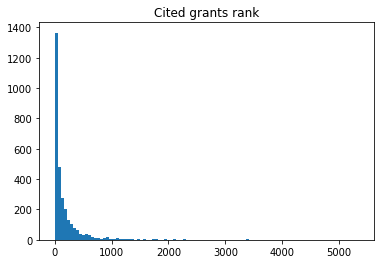

In [0]:
from matplotlib import pyplot as plt 

plt.hist(ranking, bins=100)
plt.title("Cited grants rank")
plt.show()

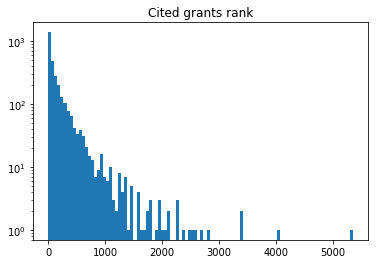

In [0]:
plt.hist(ranking, bins=100)
plt.yscale('log')
plt.title("Cited grants rank")
plt.show()

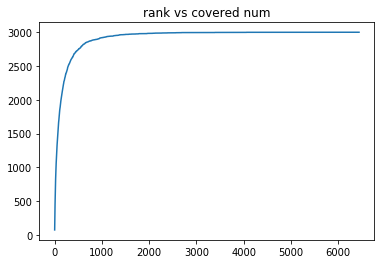

In [0]:
plt.plot(range(len(grants)), positive_counts)
plt.title("rank vs covered num")
plt.show()

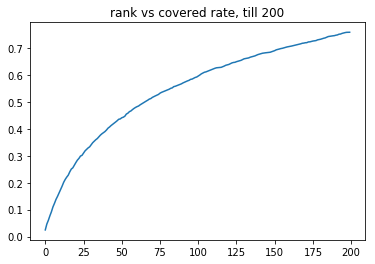

In [0]:
plt.plot(range(200), (np.array(positive_counts)/len(ranking))[0:200])
plt.title("rank vs covered rate, till 200")
plt.show()

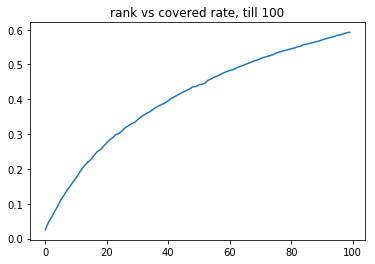

In [0]:
plt.plot(range(100), (np.array(positive_counts)/len(ranking))[0:100])
plt.title("rank vs covered rate, till 100")
plt.show()

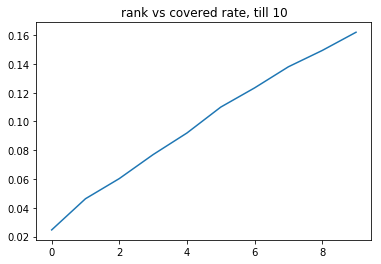

In [0]:
plt.plot(range(10), (np.array(positive_counts)/len(ranking))[0:10])
plt.title("rank vs covered rate, till 10")
plt.show()

In [0]:
print("w2v claim+background+IPC with modified ArcFace top 10   : {:.3f}".format( (np.array(positive_counts)/len(ranking))[10]))
print("w2v claim+background+IPC with modified ArcFace top 100  : {:.3f}".format( (np.array(positive_counts)/len(ranking))[100]))
print("w2v claim+background+IPC with modified ArcFace top 200  : {:.3f}\n".format( (np.array(positive_counts)/len(ranking))[200]))

w2v claim+background+IPC with modified ArcFace top 10   : 0.174
w2v claim+background+IPC with modified ArcFace top 100  : 0.596
w2v claim+background+IPC with modified ArcFace top 200  : 0.759



#Image feature extraction
https://www.tensorflow.org/tutorials/images/hub_with_keras

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

import tensorflow as tf
tf.enable_eager_execution()

In [0]:
import tensorflow_hub as hub

from tensorflow.keras import layers

In [0]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/3" #@param {type:"string"}

In [0]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 3s 0us/step


In [0]:
IMAGE_SHAPE = (224, 224)

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [0]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [0]:
module = hub.Module(feature_extractor_url, tags=['train'])
feature_extractor_layer = hub.KerasLayer(module, input_shape=(224,224,3))

RuntimeError: ignored